In [19]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
import os
from tqdm import tqdm
import numpy as np
import fiona
import pandas as pd 
from shapely.strtree import STRtree

## Part I: Creating our Graph

#### File-Paths
Understanding shapefiles: [Link](https://www.geowgs84.com/post/understanding-shapefiles-a-deep-dive-into-shp-dbf-shx-and-prj)

- `.shp`: points, lines and polygons; encoded in binary, ebgin with a fixed-length header and each feature then has its own header and content.
- `.shx`: spatial indexing - acts as an index for the `.shp` file - speeds up queries. Has fixed length records pointing to corresponding feature locations     
- `.prj`: projection file - contains the coordinate system and projection of our shapes
- `.dbf`: databased file - contains attribute data per shate - columns like name, population, elevation and the like. 

Alternatives we may see: 
- GeoJSON 
- GPKG - Geopackage

*GeoPandas can be used for all vector files. Rasterio for all raster images*


In [2]:
DATA_DIRECTORY = "data"
# Effis Fire Dataset - European Forest Fire Information System
# https://forest-fire.emergency.copernicus.eu/applications/data-and-services
FIRE_DATA_PATH = os.path.join(DATA_DIRECTORY, "fire_data/modis.ba.poly.shp")

# Several TIFFs with Wildfire Severity, once again from Effis
WILDFIRE_SEVERITY_DIR = os.path.join(DATA_DIRECTORY, "wildfire_severity")

# Natural Earth - public domain dataset of global geography
# Admin 0 – Countries dataset has country boundaries
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
COUNTRY_BOUNDARY_PATH = os.path.join(DATA_DIRECTORY, "country_boundaries/ne_110m_admin_0_countries.shp")

In [3]:
coord_ref_sys = "EPSG:25829" 
# Coordinate reference system - defines how spatial data coordinates relate to the earth. Defines origin, units, orientation

### Filter out to our target area: Portugal

In [4]:
# GeoPandas looks in the same directory for data files by default (.dbf, .shx, etc.)
fire_data = gpd.read_file(FIRE_DATA_PATH)
fire_data = fire_data.to_crs(coord_ref_sys) # reproject to our fixed CRS
fire_data = fire_data[fire_data["COUNTRY"] == "PT"]
fire_date = fire_data.iloc[:100]
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,0,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4..."
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,0,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4..."
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,0,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4..."
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,0,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4..."
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,0,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45..."


In [5]:
world = gpd.read_file(COUNTRY_BOUNDARY_PATH)
portugal = world[world["NAME"] == "Portugal"]

# https://epsg.io/25829
# Reprojection of Portugal to our fixed CRS (specified above)
portugal_proj = portugal.to_crs(coord_ref_sys) # degrees -> met
mainland = portugal_proj.iloc[portugal_proj.geometry.area.argmax()]
mainland_polygon = mainland.geometry

# Extract bordering box around Portugal
minx, miny, maxx, maxy = mainland_polygon.bounds
print(minx, miny, maxx, maxy)

454235.1439060115 4077542.239783567 718319.3451133408 4681179.434351782


In [6]:
grid_size = 3000 # meters - discretization size of what one node is in our graph
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

In [7]:
# create grid
grid_squares = []
for x in x_coords:
    for y in y_coords:
        # this makes a full rectangle grid
        cell = box(x, y, x + grid_size, y + grid_size)
        # only add cells that are inside mainland portugal (leave out the sea)
        if mainland_polygon.contains(cell):
            grid_squares.append(cell)

grid = gpd.GeoDataFrame({"geometry": grid_squares}, crs=coord_ref_sys)
grid.head()
# each entry is lower-left, upper-left, upper-right, lower-right, lower-left points of each square

,geometry
0,"POLYGON ((460235.144 4284542.24, 460235.144 42..."
1,"POLYGON ((460235.144 4287542.24, 460235.144 42..."
2,"POLYGON ((460235.144 4290542.24, 460235.144 42..."
3,"POLYGON ((460235.144 4293542.24, 460235.144 42..."
4,"POLYGON ((460235.144 4296542.24, 460235.144 42..."


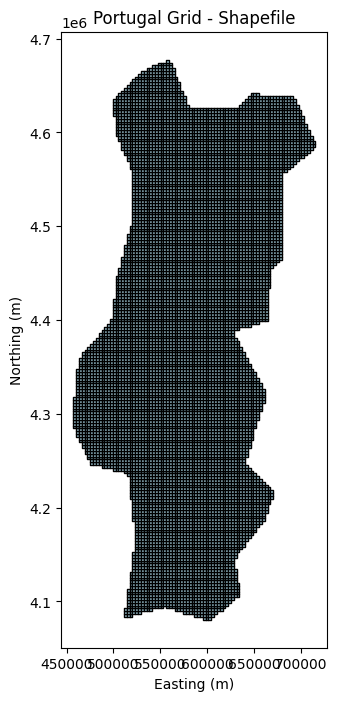

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
grid.plot(ax=ax, edgecolor='black', facecolor='lightblue')
ax.set_title("Portugal Grid - Shapefile")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.show()

In [9]:
OUTPUT_DIRECTORY = 'output'
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
grid.to_file(os.path.join(OUTPUT_DIRECTORY, "portugal_grid.shp"))
grid.to_file(os.path.join(OUTPUT_DIRECTORY,"portugal_grid.gpkg"), layer="grid", driver="GPKG")

In [10]:
# add columns for coordinates of grid squares' centers
grid_gdf = grid.copy()
#rename geometry to geometry grid
# grid_gdf = grid_gdf.rename(columns={'geometry': 'geometry_grid'})
grid_gdf["centroid_grid"] = grid.geometry.centroid
grid_gdf["centroid_x_grid"] = grid.geometry.centroid.x
grid_gdf["centroid_y_grid"] = grid.geometry.centroid.y
grid_gdf.head()

,geometry,centroid_grid,centroid_x_grid,centroid_y_grid
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (458735.144 4286042.24),458735.143906,4.286042e+06
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (458735.144 4289042.24),458735.143906,4.289042e+06
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (458735.144 4292042.24),458735.143906,4.292042e+06
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (458735.144 4295042.24),458735.143906,4.295042e+06
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (458735.144 4298042.24),458735.143906,4.298042e+06


In [24]:
# Path to GDB of Water
gdb_path = os.path.join(DATA_DIRECTORY, "rivers", "euhydro_tajo_v013.gdb")

# List of layer indices we need
layer_indices = [0, 1, 6, 8, 9]

# Read and concatenate all water layers
water_gdfs = []
for idx in layer_indices:
    layer_name = fiona.listlayers(gdb_path)[idx]
    gdf_layer = gpd.read_file(gdb_path, layer=layer_name)
    water_gdfs.append(gdf_layer)

# Combine all layers into a single GeoDataFrame
water_gdf = gpd.GeoDataFrame(pd.concat(water_gdfs, ignore_index=True))
print("Combined water bodies:", water_gdf.shape)

grid_gdf = grid_gdf.set_geometry('centroid_grid')

# Ensure the CRS matches the water layer
grid_gdf = grid_gdf.to_crs(water_gdf.crs)

water_gdf = water_gdf[water_gdf.geometry.notnull()]
water_geoms = water_gdf.geometry.values
water_tree = STRtree(water_gdf.geometry.values)

def nearest_water(point):
    if point is None or point.is_empty:
        return None
    # nearest() now returns index
    nearest_idx = water_tree.nearest(point)
    nearest_geom = water_geoms[nearest_idx]  # get the actual geometry
    return point.distance(nearest_geom)

grid_gdf['dist_to_water'] = grid_gdf.geometry.apply(nearest_water)
grid_gdf.to_crs(coord_ref_sys, inplace=True)
grid_gdf.head()


DriverError: Failed to open dataset (flags=68): data\rivers\euhydro_tajo_v013.gdb

In [11]:
grid_gdf.describe()

,centroid_x_grid,centroid_y_grid
count,10041.000000,1.004100e+04
mean,580450.411310,4.384628e+06
std,52359.087071,1.561549e+05
min,458735.143906,4.082042e+06
25%,539735.143906,4.262042e+06
50%,578735.143906,4.382042e+06
75%,620735.143906,4.520042e+06
max,713735.143906,4.676042e+06


#### Overlay with Fire Data

Assumption - if a centroid overlaps with a fire point - this is our fire node. We want to make this into a series, per date, for each fire.

In [12]:
# fires_with_centroids["centroid_x"] = fire_data["GEOMETRY"]
fire_data["centroid_x_fire"] = fire_data['geometry'].apply(lambda x: x.centroid.x)
fire_data["centroid_y_fire"] = fire_data['geometry'].apply(lambda y: y.centroid.y)
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,centroid_x_fire,centroid_y_fire
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4...",569537.929816,4.526903e+06
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4...",578340.742797,4.584768e+06
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4...",526512.771879,4.401550e+06
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4...",606905.317296,4.457301e+06
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45...",549250.037391,4.572389e+06


In [13]:
from datetime import datetime
import pandas as pd

fire_data["DAY"] = pd.to_datetime(fire_data["FIREDATE"], format='mixed').dt.date
grouped_by_day = fire_data.groupby("DAY").size().reset_index(name='fire_count')
grouped_by_day.head()

,DAY,fire_count
0,2016-05-01,2
1,2016-05-03,2
2,2016-05-04,1
3,2016-05-17,1
4,2016-06-04,1


In [14]:
def safe_stat(value, func="mean"):
    """Safely compute a statistic from a pandas Series, scalar, or missing value."""
    if value is None or isinstance(value, (float, int, np.generic, type(pd.NA))):
        return value if isinstance(value, (float, int)) else None
    
    try:
        if func == "mean":
            return value.mean()
        elif func == "sum":
            return value.sum()
        elif func == "mode":
            mode = value.mode()
            return mode.iloc[0] if not mode.empty else None
    except Exception:
        return None


Clustering in terms of weather data to reduce number of API calls

### Aggregate Grid Based on Day

# Important: This is currently set to break after one step

In [15]:
from meteostat import Point, Hourly
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
import numpy as np


fire_data = fire_data.to_crs(grid_gdf.crs)
graphs = []
for day in tqdm(grouped_by_day["DAY"]):
    fire_data_day = fire_data[fire_data["DAY"] == day].copy()
    fire_data_day['geometry'] = fire_data_day.geometry.centroid

    
    fire_centroids = fire_data_day.copy()
    fire_centroids['geometry'] = fire_data_day.geometry.centroid
    



    # Perform spatial join: fire centroid within grid polygons - Faster than iterating over each centroid - https://www.youtube.com/watch?v=y85IKthrV-s
    # We join POINT with POLYGON

    joined = gpd.sjoin(grid_gdf, fire_centroids, how="left", predicate="contains")


    joined['has_fire'] = ~joined['index_right'].isna()
    joined["geometry_centroid"] = joined.geometry.centroid
    coords = [(geom.x, geom.y) for geom in joined.geometry_centroid]

    # Note: this method does not handle an edge case where multiple fires occured at the same place,
    joined["fire_intensity"] = 0

    for filename in os.listdir(WILDFIRE_SEVERITY_DIR):
        if filename.endswith(".tiff"):
            filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
            with rasterio.open(filepath) as src:

                # Ensure CRS match
                if joined.crs != src.crs:
                    joined = joined.to_crs(src.crs)
                    joined["geometry_centroid"] = joined.geometry.centroid
                    coords = [(geom.x, geom.y) for geom in joined.geometry_centroid]

                values = np.array([val[0] for val in src.sample(coords)])
                joined["fire_intensity"] = np.maximum(joined["fire_intensity"], values)
    
    print(joined.columns)
    results = []
    i = 0
    for point, date in tqdm(zip(joined["geometry_centroid"], joined["DAY"]), total=len(joined)):
        if point is None or pd.isna(date):
            continue

        location = Point(point.y, point.x)

        # UTC timestamps for Meteostat
        start = pd.Timestamp(date)
        end = start + timedelta(days=1)

        # Fetch hourly data
        df = Hourly(location, start, end).fetch()
        if df.empty: 
            i+=1

        if not df.empty:
            # Aggregate all hours in that day
            results.append({
                "DAY": date,
                "lat": point.y,
                "lon": point.x,
                "temp_mean": safe_stat(df["temp"], "mean"),
                "rhum_mean": safe_stat(df["rhum"], "mean"),
                "wdir_mean": safe_stat(df["wdir"], "mean"),
                "wspd_mean": safe_stat(df["wspd"], "mean"),
                "pres_mean": safe_stat(df["pres"], "mean"),
            })

    weather_df = pd.DataFrame(results)
    joined = pd.concat([joined, weather_df], axis=1)
    
    
    graphs.append(joined)
    break

  0%|          | 0/1284 [00:00<?, ?it/s]UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Index(['geometry', 'centroid_grid', 'centroid_x_grid', 'centroid_y_grid',
       'index_right', 'id', 'FIREDATE', 'LASTUPDATE', 'COUNTRY', 'PROVINCE',
       'COMMUNE', 'AREA_HA', 'BROADLEA', 'CONIFER', 'MIXED', 'SCLEROPH',
       'TRANSIT', 'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC',
       'PERCNA2K', 'CLASS', 'centroid_x_fire', 'centroid_y_fire', 'DAY',
       'has_fire', 'geometry_centroid', 'fire_intensity'],
      dtype='object')



  0%|          | 0/1284 [00:13<?, ?it/s]


## 2nd try with clustering for weather data
To reduce the number of API calls

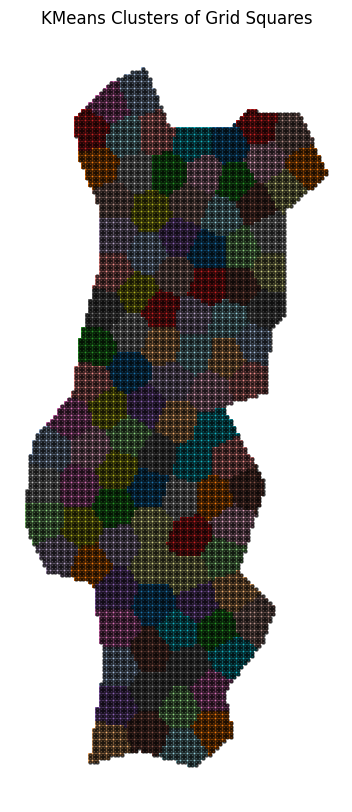

,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,geometry_centroid,cluster_id
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (458735.144 4286042.24),458735.143906,4.286042e+06,POINT (458735.144 4286042.24),29
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (458735.144 4289042.24),458735.143906,4.289042e+06,POINT (458735.144 4289042.24),29
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (458735.144 4292042.24),458735.143906,4.292042e+06,POINT (458735.144 4292042.24),29
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (458735.144 4295042.24),458735.143906,4.295042e+06,POINT (458735.144 4295042.24),29
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (458735.144 4298042.24),458735.143906,4.298042e+06,POINT (458735.144 4298042.24),29


In [31]:
from sklearn.cluster import KMeans

grid_gdf.to_crs(coord_ref_sys)
coords = np.array([(geom.y, geom.x) for geom in grid_gdf.centroid_grid])

# clustering based on geographic closeness
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
grid_gdf["cluster_id"] = kmeans.fit_predict(coords)

fig, ax = plt.subplots(figsize=(10,10))
grid_gdf.plot(column="cluster_id", categorical=True, ax=ax, cmap="tab20")
grid_gdf.geometry.centroid.plot(ax=ax, color="black", markersize=5, alpha=0.6)
ax.set_title("KMeans Clusters of Grid Squares")
ax.set_axis_off()
plt.show()

grid_gdf.head()

In [33]:
from meteostat import Point, Hourly
from datetime import timedelta

start = pd.Timestamp(fire_data["DAY"].min())
end = pd.Timestamp(fire_data["DAY"].max() + timedelta(days=1))

cluster_weather = []

for cluster_id, group in grid_gdf.groupby("cluster_id"):
    # Fetch weather data for each cluster (instead of every grid square)
    lat = group.geometry.centroid.y.mean()
    lon = group.geometry.centroid.x.mean()

    # fetch weather data for the full date range
    df_weather = Hourly(Point(lat, lon), start, end).fetch()

    if not df_weather.empty:
        daily = df_weather.resample("D").mean().reset_index() # daily mean
        daily["DAY"] = daily["time"].dt.date
        daily["cluster_id"] = cluster_id
        # temperature, relative humidity, wind direction, wind speed, air pressure
        cluster_weather.append(daily[["cluster_id", "DAY", "temp", "rhum", "wdir", "wspd", "pres"]])

weather_df = pd.concat(cluster_weather, ignore_index=True)
weather_df.to_csv("cluster_weather.csv", index=False)

weather_df.head()

,cluster_id,DAY,temp,rhum,wdir,wspd,pres
0,20,2016-05-01,20.25,55.083333,103.333333,5.25,<NA>
1,20,2016-05-02,20.333333,54.958333,103.333333,3.925,<NA>
2,20,2016-05-03,18.416667,54.041667,246.25,8.833333,<NA>
3,20,2016-05-04,16.5,54.791667,165.416667,8.954167,<NA>
4,20,2016-05-05,15.208333,55.5,142.5,9.8125,<NA>


### Original Fire Attributes
- **`id`** → Unique identifier for each fire record.  
- **`FIREDATE`** → Date and time when the fire occurred.  
- **`LASTUPDATE`** → Timestamp of the last update for the fire record.  
- **`COUNTRY`** → Country where the fire occurred.  
- **`PROVINCE`** → Province of the fire location.  
- **`COMMUNE`** → Commune (local administrative area) of the fire.  
- **`AREA_HA`** → Burned area in hectares.  

### Land Cover / Fire Area Composition
- **`BROADLEA`** → Proportion of broadleaf vegetation in the fire area.  
- **`CONIFER`** → Proportion of coniferous vegetation.  
- **`MIXED`** → Proportion of mixed forest.  
- **`SCLEROPH`** → Proportion of sclerophyllous vegetation (e.g., Mediterranean shrubs).  
- **`TRANSIT`** → Proportion of transitional land cover.  
- **`OTHERNATLC`** → Proportion of other natural land cover.  
- **`AGRIAREAS`** → Proportion of agricultural areas.  
- **`ARTIFSURF`** → Proportion of artificial surfaces (urban/industrial).  
- **`OTHERLC`** → Proportion of other land cover types.  
- **`PERCNA2K`** → Percentage of area under special designation (e.g., Natura 2000).  
- **`CLASS`** → Fire classification or severity category.  

### Fire Geometry / Location
- **`geometry`** → Original fire geometry (polygon or point).  
- **`centroid_x_fire`** → X coordinate of fire centroid.  
- **`centroid_y_fire`** → Y coordinate of fire centroid.  

### Spatial Join with Grid Cells
- **`index_right`** → Index of the grid cell containing the fire centroid (NaN if none).  
- **`centroid_grid`** → Geometry of the grid cell centroid.  
- **`centroid_x_grid`** → X coordinate of the grid cell centroid.  
- **`centroid_y_grid`** → Y coordinate of the grid cell centroid.  
- **`has_fire`** → Boolean indicating if the fire is inside a grid cell.  

### Time-Based Helper
- **`DAY`** → Date only (no time), extracted from `FIREDATE`, used for grouping fires by day.


In [ ]:
# A summary and sample of the graphs list - + persistence
import pickle
with open('output/graphs.pkl', 'wb') as f:
    pickle.dump(graphs, f)
    
print("Number of time steps(graphs)", len(graphs))
print("Example graph for one day:")
graphs[0]